# Using Sample-Level Pipeline

## A sample-level (patient-level) visualization of the gene and cell-type of interest. 

In [37]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

GOI = 'CASP8'

In [2]:
wdir = "/Users/samibening/Projects/genereporter/"
os.chdir(wdir)
adata = sc.read_h5ad("data/output/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 5397 × 16719
    obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels', 'leiden_res0_6', 'manual_celltype_annotation', 'celltypist_cell_label', 'celltypist_conf_score', 'celltypist_cell_label_coarse'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_cell_label_coarse_colors', 'celltypist_cell_label_colors', 'hvg', 'leiden', 'leiden_res0_6_colors', 'neighbors', 'pca', 'sampleID_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'int_norm', 'log_int_norm', 'log_norm', 'norm', 'raw'
    obsp: 'connectivitie

In [61]:
def sample_v_celltype(adata, GOI, return_df = False, scaled=True):
    # get data for GOI
    goi_adata = adata[:, GOI]
    goi_df = goi_adata.to_df(layer='log_norm')
    goi_df['celltype'] = goi_adata.obs['celltypist_cell_label_coarse']
    goi_df['sample'] = goi_adata.obs['sampleID']
    # calculate mean expression per celltype and sample
    goi_df_mean = goi_df.groupby(['celltype', 'sample'], observed=True).mean()
    goi_df_mean = goi_df_mean.pivot_table(index='celltype', columns='sample', values=GOI)
    goi_df_mean = goi_df_mean.fillna(0)

    if return_df:
        return goi_df_mean
    
    # sort samples by mean expression
    # (before scaling, so that the order of the samples is not affected by scaling which is only for visualization purposes)
    goi_df_mean = goi_df_mean.reindex(goi_df_mean.mean().sort_values(ascending=False).index, axis=1)

    # scale data
    if scaled:
        scaler = MinMaxScaler()
        df_scaled = scaler.fit_transform(goi_df_mean.to_numpy())
        goi_df_mean = pd.DataFrame(df_scaled, index=goi_df_mean.index, columns=goi_df_mean.columns)
    
    # plot
    g = sns.heatmap(goi_df_mean, cmap='YlGnBu', cbar_kws={'label': 'mean expression in group'})
    g.set_title(f"{GOI} expression per celltype and sample")
    plt.show()


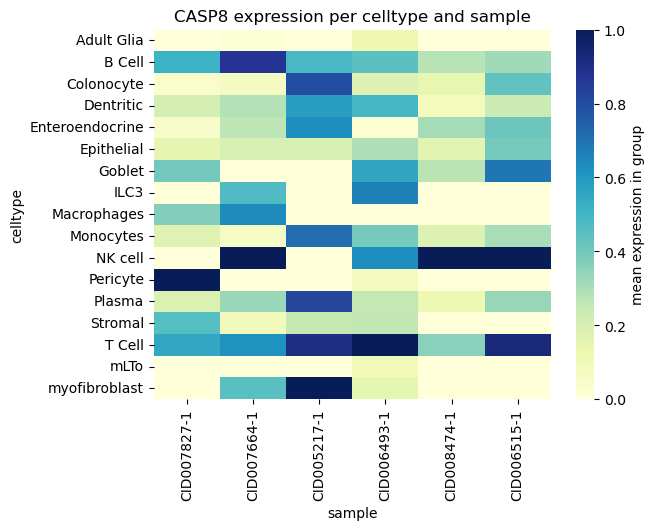

In [62]:
sample_v_celltype(adata, GOI, scaled=True)

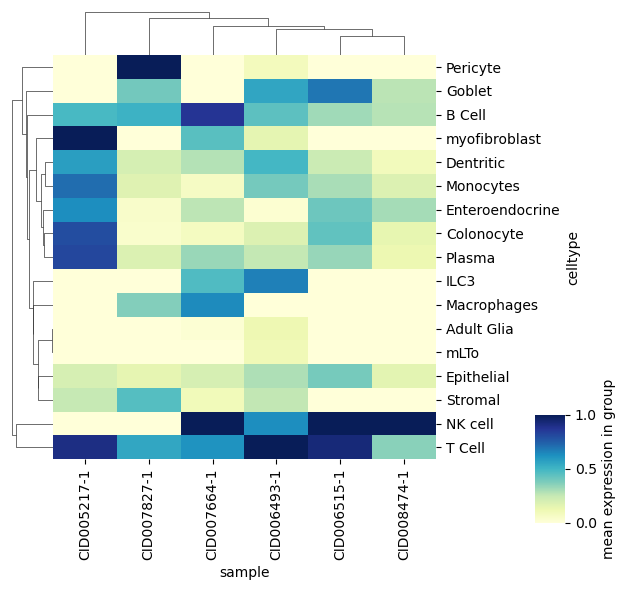

In [74]:
goi_expr = sample_v_celltype(adata, GOI, return_df=True)
sns.clustermap(goi_expr, cmap='YlGnBu', cbar_kws={'label': 'mean expression in group'}, figsize=(6, 6), 
            dendrogram_ratio=(0.1, 0.1), cbar_pos=(0.9, 0.12, 0.05, 0.18), standard_scale=1)


In [ ]:
# get GOI exression df from adata
# columns: cell type, sampleID, GOI expression
# try to make own heatmap 
# seaborn clustermap